In [91]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import os
import json
import matplotlib.lines     as mlines
import tqdm
from scipy.stats    import gmean
import torch
from torch.autograd.functional import jacobian
from time import time
from natsort                import natsorted
from matplotlib.ticker import FixedLocator


from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
rc('font', family='serif')
rc('text', usetex=True)
# plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset          as ds
import src.mace.CSE_0D.intregr_train    as intregr
import src.mace.CSE_0D.local_train      as local
import src.mace.latentODE               as lODE
import src.mace.mace                    as mace
from src.mace.CSE_0D.loss               import Loss
import src.mace.CSE_0D.loss             as loss
import src.mace.CSE_0D.plotting         as pl
import src.mace.utils                   as utils
# from src.mace.neuralODE    import Solver

def temp(Tstar, eps, r):
    Rstar = 2e13
    # r = 1e16
    T = Tstar * (r/Rstar)**(-eps)
    return T

specs_dict, idx_specs = utils.get_specs()

dt_fracts = {4 : 0.296, 5: 0.269,8: 0.221,10: 0.175,12: 0.146,16: 0.117,20: 0.09,25: 0.078,32: 0.062,48: 0.043,64: 0.033,128: 0.017}


%reload_ext autoreload
%autoreload 2

### Setup hyperparameters for mace model

In [92]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-5
epochs = 2
batch_size = 1
nb_test = 300
n_dim = 468


losstype = 'abs_idn'
z_dim = 8
nb_samples = 20
nb_hidden = 1
ae_type = 'simple'


print('------------------------------')
print('      # epochs:', epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fracts[z_dim],nb_samples=nb_samples,nb_test = nb_test, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 2
 learning rate: 1e-05
# z dimensions: 8
     # samples: 20
     loss type: abs_idn

Dataset:
------------------------------
  total # of samples: 20
#   training samples: 14
# validation samples: 6
               ratio: 0.3
     #  test samples: 300


### Local MACE training


In [66]:
## Local model

model = mace.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim,nb_hidden=nb_hidden, ae_type=ae_type, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'abs' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'abs' : 1,
         'grd' : 1,
         'idn' : 1}

plot = False


## Make loss objects
trainloss = Loss(norm, fract, losstype)
testloss  = Loss(norm, fract, losstype)


tic = time()
opt = local.train(model, lr, data_loader, test_loader, path = None, end_epochs = epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_time = time(), plot=plot)
toc = time()

print('Total time [s]:',toc-tic)




The model has 325540 trainable parameters

Model:         
learning rate: 1e-05
loss type:     abs_idn

>>> Training model...
Epoch 1 complete! 	Average loss train:  3.2456096223678097 	Average loss test:  1.3784673144556479
              time [hours]:  0.0011604746845033434
Epoch 2 complete! 	Average loss train:  3.22330834185091 	Average loss test:  1.3687090432577693
              time [hours]:  0.0019204067521625095

 	DONE!
Total time [s]: 6.914779186248779


In [67]:
trainloss.get_all_losses(), trainloss.get_losstype()


({'tot': array([0.54093494, 0.53721806]),
  'abs': array([0.2706568 , 0.26879563]),
  'grd': array([0.00016389, 0.00016379]),
  'idn': array([0.27011424, 0.26825863]),
  'elm': array([0., 0.])},
 'abs_idn')

In [68]:
model.get_status('train')

array([1822., 1822.])

In [100]:
testpath = test.testpath[5]
# print(testpath)

# print('>> Loading test data...')
input_data, info = ds.get_test_data(testpath,test)

n, n_hat, dt, mace_time = local.test(model, input_data)
n_evol, mace_evol_time = local.test_evolution(model, input_data, start_idx=0)

>>> Testing model...
torch.Size([1, 468]) torch.Size([134, 468])
(135, 468)
Solving time [s]: 0.004669904708862305

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 303.83it/s]

Solving time [s]: 0.4356715679168701
Total   time [s]: 0.4421367645263672


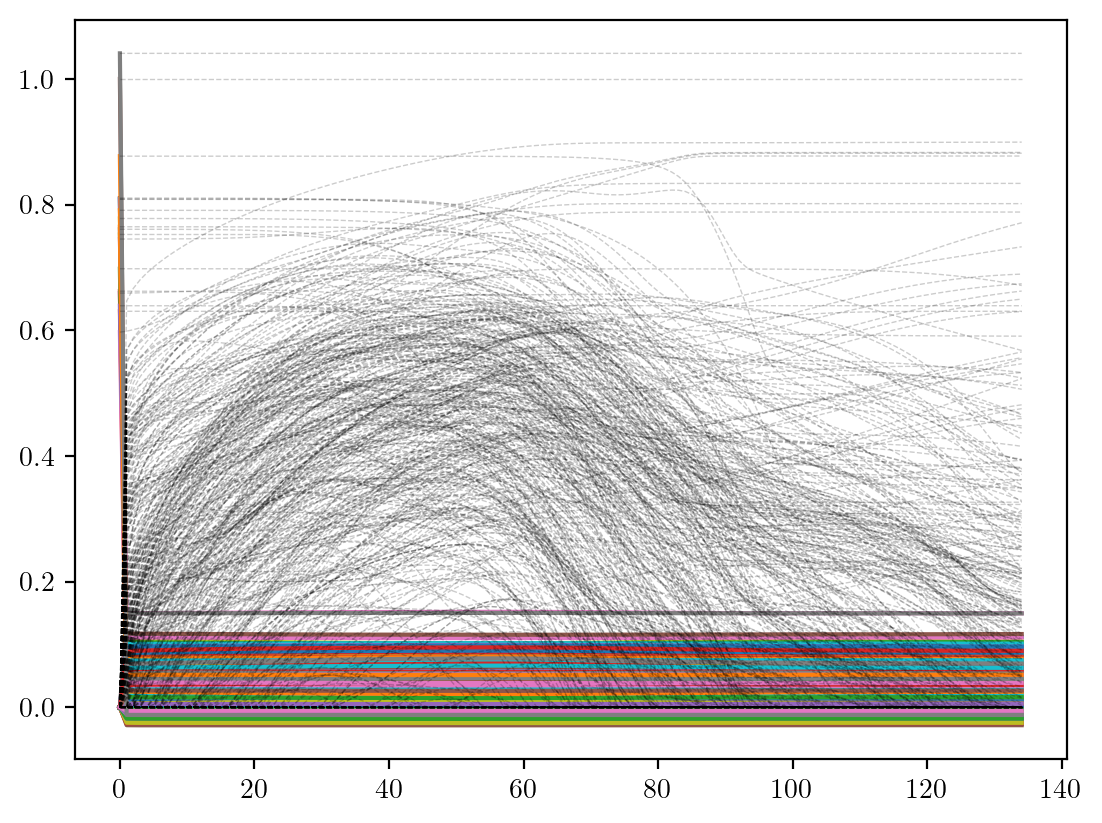

In [101]:
plt.plot(n_hat)
plt.plot(input_data[0], 'k--', alpha = 0.2, lw = 0.5)


plt.show()